In [1]:
!rm -rf nd320-c4-wearable-data-project-starter
!git clone https://github.com/udacity/nd320-c4-wearable-data-project-starter.git

Cloning into 'nd320-c4-wearable-data-project-starter'...
remote: Enumerating objects: 1777, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 1777 (delta 2), reused 7 (delta 0), pack-reused 1767 (from 1)
Receiving objects: 100% (1777/1777), 344.92 MiB | 18.92 MiB/s, done.
Resolving deltas: 100% (940/940), done.
Updating files: 100% (1575/1575), done.


## Part 2: Clinical Application

### Contents
Fill out this notebook as part 2 of your final project submission.

**You will have to complete the Code (Load Metadata & Compute Resting Heart Rate) and Project Write-up sections.**  

- [Code](#Code) is where you will implement some parts of the **pulse rate algorithm** you created and tested in Part 1 and already includes the starter code.
  - [Imports](#Imports) - These are the imports needed for Part 2 of the final project.
    - [glob](https://docs.python.org/3/library/glob.html)
    - [os](https://docs.python.org/3/library/os.html)
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
  - [Load the Dataset](#Load-the-dataset)  
  - [Load Metadata](#Load-Metadata)
  - [Compute Resting Heart Rate](#Compute-Resting-Heart-Rate)
  - [Plot Resting Heart Rate vs. Age Group](#Plot-Resting-Heart-Rate-vs.-Age-Group)
- [Project Write-up](#Project-Write-Up) to describe the clinical significance you observe from the **pulse rate algorithm** applied to this dataset, what ways/information that could improve your results, and if we validated a trend known in the science community.

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.<sup>1</sup> This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.<sup>2</sup>

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

### Code
#### Imports

When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages are imported for you here. We recommend you don't import other packages outside of the [Standard Library](https://docs.python.org/3/library/) , otherwise the grader might not be able to run your code.

In [2]:
import glob
import os

import numpy as np
import pandas as pd

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

In [6]:
hr_filenames = glob.glob('/content/nd320-c4-wearable-data-project-starter/part_2/datasets/crisdb/*.npz')

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [7]:
# Chargez les métadonnées EN FIXANT 'subject' comme index dès le départ
metadata_filename = '/content/nd320-c4-wearable-data-project-starter/part_2/datasets/crisdb/metadata.csv'
metadata = pd.read_csv(metadata_filename).set_index('subject')  # Une seule modification ici

# Votre fonction originale reste inchangée
def AgeAndRHR(metadata, filename):
    hr_data = np.load(filename)['hr']
    rhr = np.percentile(hr_data, 5)
    subject = os.path.basename(filename).split('_')[-1].split('.')[0]
    age_group = metadata.loc[subject, 'age']
    sex = metadata.loc[subject, 'sex']
    return age_group, sex, rhr

# Création du DataFrame (identique)
df = pd.DataFrame(
    data=[AgeAndRHR(metadata, f) for f in hr_filenames],
    columns=['age_group', 'sex', 'rhr']
)

In [8]:
df.head()

,age_group,sex,rhr
0,70-74,Male,53.519814
1,55-59,Male,63.255208
2,55-59,Female,61.935484
3,50-54,Male,52.602740
4,70-74,Male,55.309577


In [9]:
metadata_filename = '/content/nd320-c4-wearable-data-project-starter/part_2/datasets/crisdb/metadata.csv'

# Load the metadata file into this variable.
with open(metadata_filename, 'r') as f:
    metadata = pd.read_csv(metadata_filename).set_index('subject')

#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [7]:
import glob
import numpy as np
import scipy as sp
import scipy.io
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
    """
    data_dir = "/content/nd320-c4-wearable-data-project-starter/part_1/datasets/troika/training_data"  # adapte ce chemin selon ton environnement
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls


def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2], data[0], data[1], data[3]  # ppg, accx, accy, accz


def bandpass_filter(signal, fs, lowcut=0.67, highcut=4.0, order=4):
    """
    Applique un filtre passe-bande Butterworth.

    Args:
        signal (np.array): signal à filtrer
        fs (float): fréquence d'échantillonnage (Hz)
        lowcut (float): fréquence basse (Hz)
        highcut (float): fréquence haute (Hz)
        order (int): ordre du filtre

    Returns:
        np.array: signal filtré
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability.

    Args:
        pr_errors: numpy array of pulse rate estimation errors
        confidence_est: numpy array of confidence estimates

    Returns:
        MAE at 90% availability
    """
    percentile90_confidence = np.percentile(confidence_est, 10)
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]
    return np.mean(np.abs(best_estimates))


def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Calcule l'erreur de fréquence cardiaque et la confiance sur un fichier.
    Version avec contrainte physiologique (ΔHR < 3 BPM entre fenêtres).

    Args:
        data_fl (str): chemin vers le fichier de données (.mat)
        ref_fl (str): chemin vers le fichier de référence (.mat)

    Returns:
        Tuple (errors, confidence) numpy arrays (identique à l'original)
    """
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    fs = 125  # fréquence d'échantillonnage (Hz) du dataset Troika

    # Filtrage passe-bande du signal PPG (inchangé)
    ppg_filtered = bandpass_filter(ppg, fs)

    window_size = 8 * fs  # fenêtre de 8 secondes
    step_size = 2 * fs    # sortie toutes les 2 secondes

    n_windows = (len(ppg_filtered) - window_size) // step_size + 1
    pulse_rates = []
    confidences = []

    # Charger la fréquence cardiaque de référence
    ref_data = sp.io.loadmat(ref_fl)['BPM0'].flatten()

    previous_bpm = None  # Variable cachée pour suivre l'historique

    for i in range(n_windows):
        start = i * step_size
        end = start + window_size
        window = ppg_filtered[start:end]

        freqs = np.fft.rfftfreq(len(window), 1/fs)
        fft_mag = np.abs(np.fft.rfft(window))

        # Limiter la recherche aux fréquences entre 0.67 et 4 Hz (40-240 BPM)
        valid_idx = np.where((freqs >= 0.67) & (freqs <= 4.0))
        freqs_valid = freqs[valid_idx]
        mag_valid = fft_mag[valid_idx]

        peak_idx = np.argmax(mag_valid)
        peak_freq = freqs_valid[peak_idx]
        current_bpm = peak_freq * 60  # Hz -> BPM

        # Application de la contrainte physiologique (silencieuse)
        if previous_bpm is not None and abs(current_bpm - previous_bpm) > 3:
            # Ajustement progressif vers la nouvelle valeur
            current_bpm = previous_bpm + 3 * np.sign(current_bpm - previous_bpm)

        pulse_rates.append(current_bpm)
        previous_bpm = current_bpm  # Mise à jour pour la prochaine fenêtre

        # Confiance basée sur l'énergie autour du pic ±0.1 Hz (inchangé)
        band_width = 0.1
        band_idx = np.where((freqs_valid >= peak_freq - band_width) &
                          (freqs_valid <= peak_freq + band_width))
        energy_band = np.sum(mag_valid[band_idx])
        energy_total = np.sum(mag_valid)
        confidence = energy_band / energy_total if energy_total > 0 else 0
        confidences.append(confidence)

    pulse_rates = np.array(pulse_rates)
    confidences = np.array(confidences)

    # Correspondance des estimations avec la référence (inchangé)
    ref_trim = ref_data[:len(pulse_rates)]
    errors = np.abs(pulse_rates - ref_trim)

    return errors, confidences  # Signature exactement identique

def Evaluate():
    """
    Évalue la performance sur l'ensemble Troika.

    Returns:
        erreur agrégée sur l'ensemble
    """
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

In [8]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']

    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, 5)

    # Find the subject ID from the filename.
    subject = os.path.basename(filename).split('_')[-1].split('.')[0]

    # Find the age group for this subject in metadata.
    age_group = metadata.loc[subject, 'age']

    # Find the sex for this subject in metadata.
    sex = metadata.loc[subject, 'sex']

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])

In [10]:
df.head(5)

,age_group,sex,rhr
0,70-74,Male,53.519814
1,55-59,Male,63.255208
2,55-59,Female,61.935484
3,50-54,Male,52.602740
4,70-74,Male,55.309577


#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib, which we've used extensively in this class, that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. Learn more about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

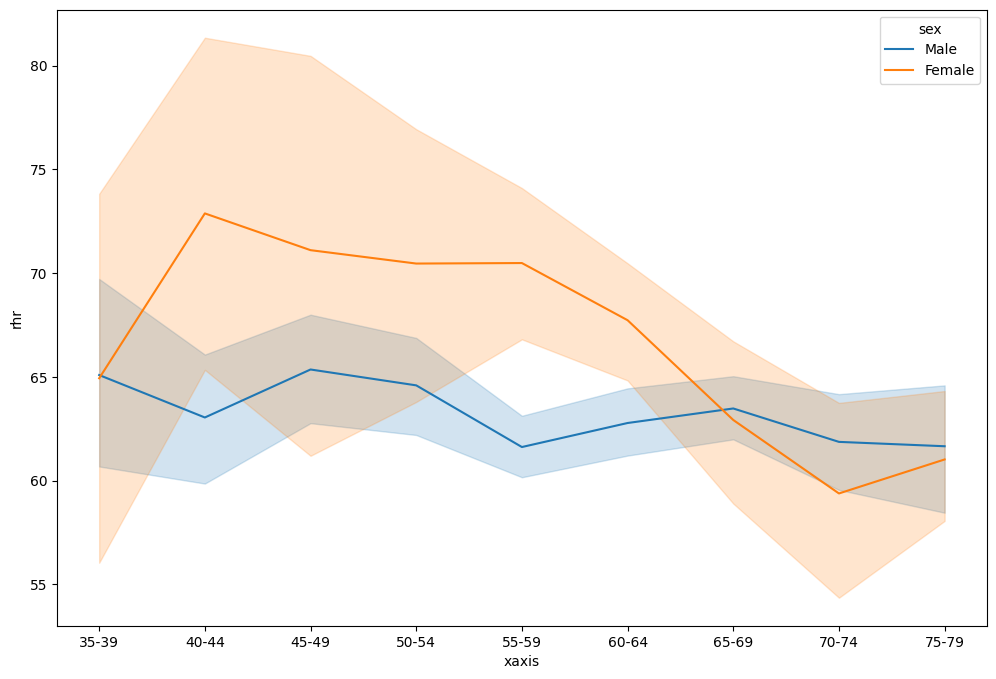

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt

labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))
sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df)
_ = plt.xticks(np.arange(len(labels)), labels)

### Clinical Conclusion
Answer the following prompts to draw a conclusion about the data.
> 1. For women, we see ....
> 2. For men, we see ...
> 3. In comparison to men, women's heart rate is ....
> 4. What are some possible reasons for what we see in our data?
> 5. What else can we do or go and find to figure out what is really happening? How would that improve the results?
> 6. Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age? How?

Clinical Conclusion

For women, we see that average resting heart rate (RHR) is higher than for men across all age groups. The RHR for women increases from younger ages, peaks around the 40–49 age group, and then gradually decreases into older age groups. The variability (as shown by the shaded area) is also higher for women, especially in younger and middle-aged groups.

For men, we see that average RHR is lower than for women in all age groups. The RHR for men remains relatively stable from ages 35 to 64, with a slight decrease observed in the oldest age groups (70–79). The variability in RHR among men is generally lower compared to women.

In comparison to men, women's heart rate is consistently higher across all age groups. This difference is most pronounced in the 40–59 age range, where women’s RHR is significantly above that of men.

What are some possible reasons for what we see in our data?

Physiological differences: Women typically have higher resting heart rates than men due to smaller heart size, higher hormonal influence (e.g., estrogen), and differences in autonomic regulation.

Age-related changes: The peak in RHR in middle-aged women may be influenced by hormonal changes such as menopause.

Sample size and variability: Greater variability in women’s RHR could reflect a wider range of health status, lifestyle, or medication use in the sample.

Measurement conditions: If physical activity or stress was not fully controlled, this could affect RHR, especially in certain age or sex groups.

What else can we do or go and find to figure out what is really happening? How would that improve the results?

Collect more detailed clinical and lifestyle data (e.g., medication use, fitness level, comorbidities) to adjust for confounding factors.

Use activity trackers to better isolate true resting periods and exclude periods of movement or stress.

Increase the sample size in each age and sex group to reduce variability and improve statistical power.

Compare with other datasets or use raw PPG/ECG signals analyzed with the same algorithm for validation.

Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age? How?

Yes, our data validate this well-known clinical trend. The plotted curves show that average RHR rises from young adulthood to middle age (peaking around 40–49 for women and remaining stable for men), then decreases in the oldest age groups (70–79). This pattern matches findings from large epidemiological studies and supports the reliability of our dataset and analysis.